# Техническое задание

Построить модель обучения, предсказывающую отсутствие товара на полке в момент времени без продаж, используя оценку вероятности отсутствия товара.

# Предоставленные данные

Заказчиком был предоставлен к следующим таблицам в БД (microsoft sql):
1) dbo.Features - основной датасет состоящий из столбцов с магазинами, товарами, датой получения информации о наличии товара на полке, вероятность отсутствия, истинный результат (1 - отсутствие) и столбцы признаков.
2) dbo.LocationStateHourSales - статистика ежечасных продаж товаров по магазинам
3) dbo.LocationStateStocks - информация по остаткам товаров в магазинах<br>

Для записей из dbo.Features с отсутствующими значениями IsCorrect (отсутствия товара) нужно предсказать.

Запрос для примера:<br>
query_features = "select * from dbo.Features"<br>
df = pd.read_sql(query_features, conn)<br>
df <br>

# Импорт необходимых библиотек

In [104]:
#pip install pyodbc
#!pip install seaborn


In [105]:
import datetime
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
import shap

import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score
from catboost import CatBoostClassifier

# Загрузка данных

Доступ к базе

In [106]:
# Параметры подключеия к базе

conn_str = """
    Driver={ODBC Driver 17 for SQL Server};
    Server=109.71.11.235;
    Database=GFC.Hackathon;
    UID=participant;
    PWD=AiNRYmEatiBL;
"""

conn = pyodbc.connect(conn_str)

Блок функций

In [107]:
# Получение количества и даты последней продажи товара на момент выгрузки данных
def add_sales_sale_sql (row, conn=conn):
    dt = str(row['ValidationDateTime'])[:-3]
    s1_query = "select top 1 (CAST(Datetime as datetime)) as dt,\
                Quantity as qua\
                from dbo.LocationStateHourSales\
                where (LocationId = "+str(row['LocationId'])+") AND \
                      (ProductId = "+str(row['ProductId'])+") AND \
                      (CAST(Datetime as datetime) < CAST('"+str(dt)+"' as datetime))\
                order by dt DESC"   
    s1 = pd.read_sql(s1_query, conn)
    row['last_sale'] = (s1.loc[0]['dt'])
    row['last_sale_units'] = (s1.loc[0]['qua'])
    print('-', end='')
    return row

# Получение остатков товара на момент выгрузки данных
def add_sales_stock_sql (row, conn=conn):
    s1_query = "select top 1 Quantity, \
                             CAST(Datetime as datetime) as dt\
                from dbo.LocationStateStocks\
                where (LocationId = "+str(row['LocationId'])+") AND \
                      (ProductId = "+str(row['ProductId'])+") AND \
                      (CAST(Datetime as datetime) < CAST('"+str(dt)+"' as datetime))\
                order by dt DESC"   
    s1 = pd.read_sql(s1_query, conn)
    row['last_stock'] = (s1.loc[0]['Quantity'])
    return row

# Сокращение для выгрузки данных из базы
def sql_query(query, conn=conn):
     return pd.read_sql(query, conn)

Выгрузка тренировочной выборки

In [108]:
# для обучения модели используем записи с IsCorrect is not null
train_query = "select * from dbo.Features f where f.IsCorrect is not null"
train_df = pd.read_sql(train_query, conn)
train_df.head(5)

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07,0.416474,False,86.0,85.0,0.011628,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
1,63,288606,2023-06-01 15:32:31,0.687710,False,8.0,7.0,0.125000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
2,63,288606,2023-06-03 12:55:49,0.810382,False,10.0,9.0,0.100000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
3,63,288606,2023-06-07 14:57:38,0.312500,False,4.0,3.0,0.250000,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0
4,63,288606,2023-06-09 14:56:35,0.605429,False,6.0,5.0,0.166667,None,None,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,None,0.0


Выгрузка тестовой выборки

In [109]:
# тестовая выборка (то, что используется в финальном зачете) - записи с IsCorrect is null
test_query = "select * from dbo.Features f where f.IsCorrect is null"
test_df = pd.read_sql(test_query, conn)
test_df.head(5)

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288606,2023-07-25 14:57:04,0.406708,None,14.0,13.0,0.071429,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
1,63,288606,2023-08-03 14:58:53,0.460643,None,2.0,1.0,0.500000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
2,63,288783,2023-07-24 14:57:11,0.404959,None,4.0,4.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
3,63,288783,2023-08-03 14:57:39,0.659497,None,0.0,-1.0,NaN,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0
4,63,289136,2023-07-24 14:57:09,0.299769,None,6.0,6.0,0.000000,None,None,...,0.0,0.0,0.0,0.0,1,0,0.0,0,None,0


Знакомство с стаблицами sales и stocks

In [110]:
# дополнительные таблицы с почасовыми продажами и остатками - мы ждем отвас новых интересных признаков :)
sales_query = "select top 5 * from dbo.LocationStateHourSales" 
sales = pd.read_sql(sales_query, conn)
sales

,LocationId,ProductId,Datetime,Quantity,PriceSum,Date
0,63,288606,2023-05-01 12:00:00,6.0,179.940002,2023-05-01
1,63,288606,2023-05-01 13:00:00,2.0,59.980000,2023-05-01
2,63,288783,2023-05-01 17:00:00,2.0,259.799988,2023-05-01
3,63,288913,2023-05-01 16:00:00,1.0,129.899994,2023-05-01
4,63,289117,2023-05-01 11:00:00,3.0,92.970001,2023-05-01


In [111]:
stocks_query = "select top 5 * from dbo.LocationStateStocks" 
stocks = pd.read_sql(stocks_query, conn)
stocks

,LocationId,ProductId,Datetime,Quantity,Date
0,63,288524,2023-05-01,21.0,2023-05-01
1,63,288527,2023-05-01,181.0,2023-05-01
2,63,288606,2023-05-01,6.0,2023-05-01
3,63,288783,2023-05-01,11.0,2023-05-01
4,63,288817,2023-05-01,18.0,2023-05-01


# Краткий анализ данных

Выясним количество магазинов и продуктов

In [112]:
print('Количество магазинов:', len(train_df['LocationId'].unique()))
print('Количество товаров:', len(train_df['ProductId'].unique()))

Количество магазинов: 323
Количество товаров: 3156


Посмотрим как часто интересуются оттсутствием на полке того или иного товара

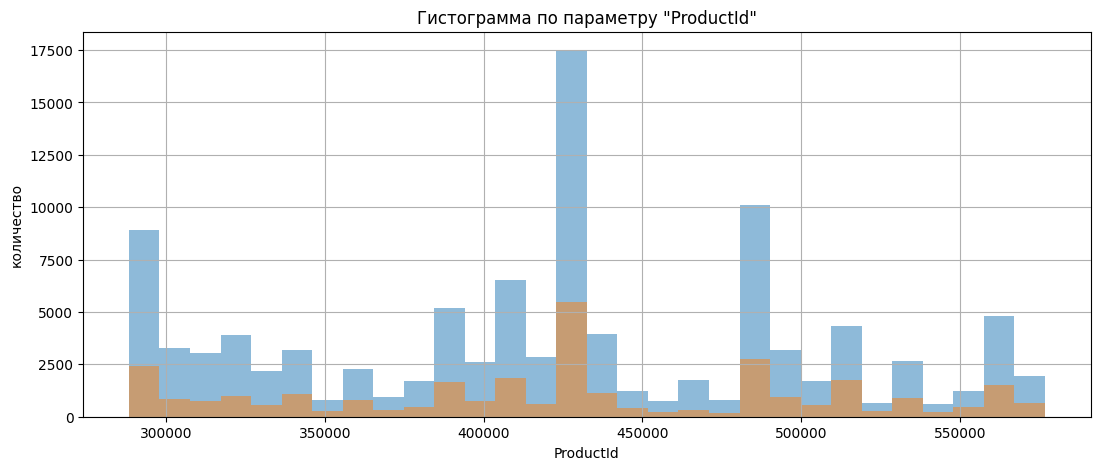

In [113]:
train_df.groupby('IsCorrect')['ProductId'].hist(bins=30, alpha=0.5, figsize=(13,5))
plt.title('Гистограмма по параметру "ProductId"')
plt.xlabel('ProductId')
plt.ylabel('количество')
plt.show() 

Баланс классов

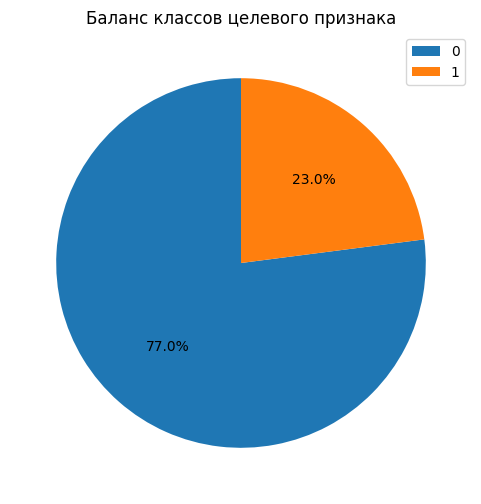

In [114]:
train_df.groupby('IsCorrect').size().plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(6,6), \
                                            labels = None)
plt.legend(['0', '1'])
plt.title('Баланс классов целевого признака')
plt.ylabel('')
plt.show();

# Предобработка данных

### Преобразования дат в корректный формат

In [115]:
train_df.sort_values('ValidationDateTime', inplace=True)
test_df.sort_values('ValidationDateTime', inplace=True)

### Общая информация об обучающей выборке

In [116]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135847 entries, 117948 to 45214
Data columns (total 66 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LocationId          135847 non-null  int64         
 1   ProductId           135847 non-null  int64         
 2   ValidationDateTime  135847 non-null  datetime64[ns]
 3   Probability         135667 non-null  float64       
 4   IsCorrect           135847 non-null  bool          
 5   Column6             135847 non-null  float64       
 6   Column7             135847 non-null  float64       
 7   Column8             107830 non-null  float64       
 8   Column9             0 non-null       object        
 9   Column10            0 non-null       object        
 10  Column11            135847 non-null  float64       
 11  Column12            135847 non-null  int64         
 12  Column13            40566 non-null   float64       
 13  Column14            135846 non

In [117]:
train_df.isnull().sum()

LocationId                 0
ProductId                  0
ValidationDateTime         0
Probability              180
IsCorrect                  0
                       ...  
Column63                   1
Column64                   1
Column65                   1
Column66              135847
Column67                   1
Length: 66, dtype: int64

In [118]:
train_df.describe()

,LocationId,ProductId,ValidationDateTime,Probability,Column6,Column7,Column8,Column11,Column12,Column13,...,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column67
count,135847.000000,135847.000000,135847,135667.000000,135847.000000,135847.000000,107830.000000,135847.000000,135847.000000,40566.000000,...,135846.000000,135846.0,135846.0,135846.0,135846.0,135846.0,135846.0,135846.0,135846.0,135846.0
mean,1669.974317,422605.196604,2023-06-30 16:14:03.369272576,0.670913,4.946373,4.041341,0.352331,4.379663,20.512510,4.453248,...,61.360668,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
min,63.000000,288312.000000,2023-06-01 14:44:35.147000,-1.000000,0.000000,-2.000000,0.000000,0.035714,0.000000,0.000000,...,0.200000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,873.000000,357870.000000,2023-06-19 14:58:12,0.475120,1.000000,0.000000,0.076923,2.214286,17.000000,2.058824,...,26.990000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
50%,1736.000000,425848.000000,2023-07-02 15:00:46,0.755140,3.000000,2.000000,0.250000,3.464286,22.000000,3.166667,...,50.990002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
75%,2553.000000,485344.000000,2023-07-12 15:15:56,0.965797,6.000000,5.000000,0.500000,5.250000,26.000000,5.100000,...,78.230001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
max,2950.000000,576749.000000,2023-07-21 17:22:26.517000,1.000000,89.000000,89.000000,2.000000,386.107147,28.000000,386.190491,...,1650.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
std,887.816815,79773.753520,NaN,0.350718,8.272221,8.275806,0.379249,4.510210,6.059057,5.841699,...,49.035788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Полученные данные достаточно сырые с большим количеством пропусков

### Строки дубликаты

In [119]:
# Смотрим дубликаты
train_df[train_df.duplicated]

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,...,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67


### Пустые и константные признаки

In [120]:
threshold = 1
# Создем список константных признаков
constant_features = [
    feature for feature in train_df.columns if train_df[feature].value_counts(normalize=True).max() >= threshold
]
# Удаляем константные признаки
train_df.drop(columns=constant_features, inplace=True)

In [121]:
# Удаляем столбцы, в которых все значения пусты
train_df.dropna(axis=1, how='all', inplace=True)

### Признаки с большим количеством пропусков

In [123]:
threshold = 0.5  # 50% порог

#  список столбцов с более чем 50% пропусков
columns_with_missing_values = train_df.columns[train_df.isnull().mean() > threshold]

print(columns_with_missing_values)

Index(['Column13', 'Column20', 'Column22', 'Column28'], dtype='object')


In [124]:
# Вывести значения столбцов с более чем 50% пропусков
for column in columns_with_missing_values:
    print(f"Column: {column}")
    print(train_df[column])

Column: Column13
117948     4.544333
117815     3.000000
117813     6.400000
117902     2.000000
67140      2.733333
            ...    
81151      2.466667
80402     15.555555
68471      6.166667
68475      1.000000
45214      9.333333
Name: Column13, Length: 135847, dtype: float64
Column: Column20
117948   NaN
117815   NaN
117813   NaN
117902   NaN
67140    NaN
          ..
81151    NaN
80402    NaN
68471    NaN
68475    NaN
45214    NaN
Name: Column20, Length: 135847, dtype: float64
Column: Column22
117948   NaN
117815   NaN
117813   NaN
117902   NaN
67140    NaN
          ..
81151    NaN
80402    NaN
68471    NaN
68475    NaN
45214    NaN
Name: Column22, Length: 135847, dtype: float64
Column: Column28
117948    1.380952
117815    1.500000
117813    1.888889
117902         NaN
67140     0.857143
            ...   
81151     1.166667
80402     3.666667
68471          NaN
68475          NaN
45214          NaN
Name: Column28, Length: 135847, dtype: float64


In [125]:
# Вывести уникальные значения в каждом столбце
for column in columns_with_missing_values:
    unique_values = train_df[column].unique()
    print(f"Column: {column}")
    print(unique_values)
    print()

Column: Column13
[ 4.54433346  3.          6.4000001  ...  3.0434444   3.78841662
 15.55555534]

Column: Column20
[nan 18.  4. 11.  6.  7. 26. 27. 15.  1.  8. 22. 21. 19. 20.  5.  2. 12.
  9. 28. 16. 23. 13. 24.  3. 17. 29. 10. 14. 25. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 56. 57. 58. 59. 60. 61. 55. 63. 64. 65. 66. 67. 68. 62. 69. 70. 71.
 72. 73. 74. 76.]

Column: Column22
[       nan 1.         0.83333331 0.75       0.93333334 0.94444442
 0.90909094 0.94736844 0.875      0.9375     0.91666669 0.80000001
 0.89999998 0.92307693 0.85714287 0.8888889  0.95833331 0.66666669
 0.94117647 0.9285714  0.5        0.95652175 0.96296299 0.96774191
 0.94999999 0.97368419 0.97142857 0.96551722 0.97058821 0.96153843]

Column: Column28
[1.38095236 1.5        1.88888884        nan 0.85714287 1.47619045
 1.73684216 0.73333335 1.36363637 1.32558143 1.60000002 0.92592591
 1.26086962 1.         1.16666663 0.79310346 1.08000004 6.
 2.25      

### Добавление новых признаков

Временные

In [138]:
# TS features

train_df['weekday'] = train_df['ValidationDateTime'].apply(lambda x: x.weekday())
train_df['day'] = train_df['ValidationDateTime'].apply(lambda x: x.day)
train_df['hour'] = train_df['ValidationDateTime'].apply(lambda x: x.hour)

test_df['weekday'] = test_df['ValidationDateTime'].apply(lambda x: x.weekday())
test_df['day'] = test_df['ValidationDateTime'].apply(lambda x: x.day)
test_df['hour'] = test_df['ValidationDateTime'].apply(lambda x: x.hour)



Из статистики продаж (дата последней продажи и количество проданного)

# Матрица корреляции

Для построения матрицы корреляции с учетом наличия категориальных признаков используем инструменты библиотеки phik

In [ ]:
cat_features = ['Column12', 
                'Column18', 
                'Column19', 
                'Column21', 
                'Column24', 
                'Column25', 
                'Column45', 
                'Column46', 
                'Column47', 
                'Column49', 
                'Column50', 
                'Column51', 
                'Column52',
                'weekday',
                'day',
                'hour']

num_features = list(set(features) - \
                    set(cat_features) - \
                    set(['ValidationDateTime'])) + \
               ['last_sale_hours'] + \
               ['last_sale_units']

In [ ]:
data_corr = new_train[[*features, 'IsCorrect']].phik_matrix(interval_cols=num_features)
plot_correlation_matrix(data_corr.values, 
                            x_labels=data_corr.columns, 
                            y_labels=data_corr.index, 
                            vmin=0, vmax=1, color_map="Greens", 
                            title=r"correlation $\phi_K$", 
                            fontsize_factor=1, 
                            figsize=(16, 12))

Линейной зависимости с целевой переменной практически нет. Присутствует мультиколлинеарность.<br>
При использовании модели catboost устранение мультиколлинеарности не является необходимостью

# Обучение моделей предсказания

### Обучение модели на тестовых данных с выделением валидационной выборки

In [127]:
# Определяем целевую переменную
target = 'IsCorrect'

# Разделяем данные
train_data = train_df[train_df['ValidationDateTime'] < '2023-07-15']
test_data = train_df[train_df['ValidationDateTime'] >= '2023-07-15']

In [128]:
columns_to_exclude = ['ValidationDateTime']

# SimpleImputer с выбранным методом заполнени
imputer = SimpleImputer(strategy='median')

# SimpleImputer train
numerical_columns = [col for col in train_data.columns if col not in columns_to_exclude]
train_data[numerical_columns] = imputer.fit_transform(train_data[numerical_columns])

# SimpleImputer test
numerical_columns = [col for col in test_data.columns if col not in columns_to_exclude]
test_data[numerical_columns] = imputer.fit_transform(test_data[numerical_columns])

In [129]:
print("Размер train_data:", train_data.shape)
print("Размер test_data:", test_data.shape)
print("Размер train_df:", train_df.shape)


Размер train_data: (110912, 56)
Размер test_data: (24935, 56)
Размер train_df: (135847, 56)


In [130]:
train_data_percent = (train_data.shape[0] / train_df.shape[0]) * 100
test_data_percent = (test_data.shape[0] / train_df.shape[0]) * 100

print("train_data составляет {:.2f}% от train_df_filled".format(train_data_percent))
print("test_data составляет {:.2f}% от train_df_filled".format(test_data_percent))

train_data составляет 81.64% от train_df_filled
test_data составляет 18.36% от train_df_filled


In [131]:
features = [col for col in train_data.columns if col != target]

# Создаем и обучаем модель CatBoost
model = CatBoostClassifier(iterations=700, learning_rate=0.07, depth=8, random_state=42, verbose=False)
model.fit(train_data[features], train_data[target])

In [132]:
predictions = model.predict(test_data[features])

# Предсказание вероятности наличия товара на полке на тестовом наборе
test_data['CalculatedProbability'] = model.predict_proba(test_data[features])[:, 1]

# Вычислите AUC-ROC на тестовом наборе
roc_auc = roc_auc_score(test_data[target], model.predict_proba(test_data[features])[:, 1])
print("AUC-ROC Score на тестовых данных:", roc_auc)


AUC-ROC Score на тестовых данных: 0.8118617868839677


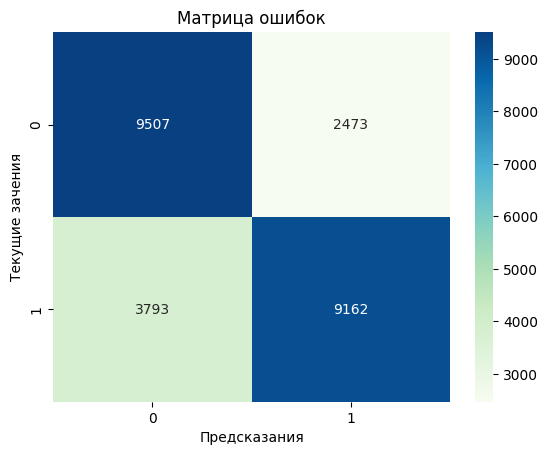

In [133]:
cm = confusion_matrix(test_data[target], predictions)
sns.heatmap(cm, 
            annot=True, 
            fmt='.0f',
            cmap='GnBu')
plt.title('Матрица ошибок')
plt.xlabel('Предсказания')
plt.ylabel('Текущие зачения');

In [219]:
test_data[['LocationId', 
           'ProductId', 
           'ValidationDateTime', 
           'CalculatedProbability']].to_csv('Podval_test.csv', 
                                            sep=';', 
                                            index=False)

### Обучение модели на тестовых данных с выделением валидационной выборки

In [ ]:
test_data

In [141]:
train_data = train_df
test_data = test_df[train_df.columns]
test_data['IsCorrect'] = 0

In [142]:
columns_to_exclude = ['ValidationDateTime']

# SimpleImputer с выбранным методом заполнени
imputer = SimpleImputer(strategy='median')

# SimpleImputer train
numerical_columns = [col for col in train_data.columns if col not in columns_to_exclude]
train_data[numerical_columns] = imputer.fit_transform(train_data[numerical_columns])

# SimpleImputer test
numerical_columns = [col for col in test_data.columns if col not in columns_to_exclude]
test_data[numerical_columns] = imputer.fit_transform(test_data[numerical_columns])

In [143]:
print("Размер train_data:", train_data.shape)
print("Размер test_data:", test_data.shape)
print("Размер train_df:", train_df.shape)

Размер train_data: (135847, 56)
Размер test_data: (40771, 56)
Размер train_df: (135847, 56)


In [144]:
features = [col for col in train_data.columns if col != target]

# Создаем и обучаем модель CatBoost
model = CatBoostClassifier(iterations=700, learning_rate=0.07, depth=8, random_state=42, verbose=False)
model.fit(train_data[features], train_data[target])

In [145]:
predictions = model.predict(test_data[features])

# Предсказание вероятности наличия товара на полке на тестовом наборе
test_data['CalculatedProbability'] = model.predict_proba(test_data[features])[:, 1]

In [146]:
test_data[['LocationId', 
           'ProductId', 
           'ValidationDateTime', 
           'CalculatedProbability']].to_csv('Podval_20.csv', 
                                            sep=';', 
                                            index=False)

# Вывод

По предоставленным заказчиком данным были изучены данные торговой сети, содержащие временные метки по магазинам и товарным позициям, в момент которых выявлялись наличия пустых полок, вероятность данного события, вычисленная заказчиком, а также признаки.<br>
Были выявлены и устранены множественные пропуски с помощью устранение неинформативных признаков и заполнения медианным значением. Построена матрица корреляции для выявления линейных связи между признаками между собой, а также с целевой переменной (фактом отсутствия товарной позиции на полке).<br>
В качестве модели машинного обучения использовалась модель CatBoost с ручным подбором гиперпараметров. Построена матрица ошибок, для контроля выявления именно отсутвия товара на полке, а не наличия, а также контроля ошибок модели.<br>
Метрика AUC-ROC данной модели на валидационной выборке составила 0.811